# Quick Start Tutorial

GluonTS contains:

* A number of pre-built models
* Components for building new models (likelihoods, feature processing pipelines, calendar features etc.)
* Data loading and processing
* Plotting and evaluation facilities
* Artificial and real datasets (only external datasets with blessed license)

In [15]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

## Datasets

### Provided datasets

GluonTS comes with a number of publicly available datasets.

In [16]:
from gluonts.dataset.repository import get_dataset, dataset_names
from gluonts.dataset.util import to_pandas

In [5]:
print(f"Available datasets: {dataset_names}")

Available datasets: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki2000_nips', 'wiki-rolling_nips', 'taxi_30min', 'kaggle_web_traffic_with_missing', 'kaggle_web_traffic_without_missing', 'kaggle_web_traffic_weekly', 'm1_yearly', 'm1_quarterly', 'm1_monthly', 'nn5_daily_with_missing', 'nn5_daily_without_missing', 'nn5_weekly', 'tourism_monthly', 'tourism_quarterly', 'tourism_yearly', 'cif_2016', 'london_smart_meters_without_missing', 'wind_farms_without_missing', 'car_parts_without_missing', 'dominick', 'fred_md', 'pedestrian_counts', 'hospital', 'covid_deaths', 'kdd_cup_2018_without_missing', 'weather', 'm3_monthly', 'm3_quarterly', 'm3_yearly', 'm3_other', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5', 'uber_tlc_daily', 'uber_tlc_hourly', 'airpassengers', 'australian_electricity_demand', 'electricity_hourly', 'electricity_weekly', 'rideshare_wit

To download one of the built-in datasets, simply call get_dataset with one of the above names. GluonTS can re-use the saved dataset so that it does not need to be downloaded again the next time around.

In [6]:
dataset = get_dataset("m4_hourly")

In general, the datasets provided by GluonTS are objects that consists of three main members:

- `dataset.train` is an iterable collection of data entries used for training. Each entry corresponds to one time series.
- `dataset.test` is an iterable collection of data entries used for inference. The test dataset is an extended version of the train dataset that contains a window in the end of each time series that was not seen during training. This window has length equal to the recommended prediction length.
- `dataset.metadata` contains metadata of the dataset such as the frequency of the time series, a recommended prediction horizon, associated features, etc.

/Users/sergiocalderon/anaconda3/envs/GluonTSMXnet/lib/python3.11/site-packages/gluonts/dataset/common.py:262: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return pd.Period(val, freq)


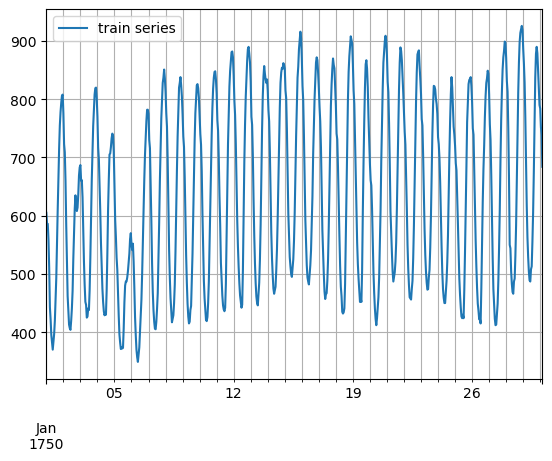

In [7]:
entry = next(iter(dataset.train))
train_series = to_pandas(entry)
train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.show()

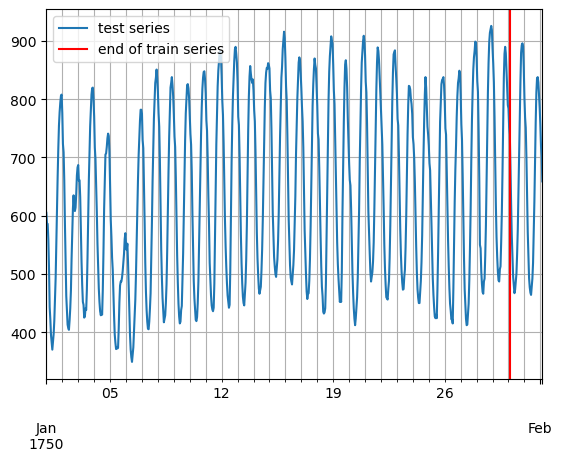

In [8]:
entry = next(iter(dataset.test))
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(train_series.index[-1], color="r")  # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.show()

In [9]:
print(
    f"Length of forecasting window in test dataset: {len(test_series) - len(train_series)}"
)
print(f"Recommended prediction horizon: {dataset.metadata.prediction_length}")
print(f"Frequency of the time series: {dataset.metadata.freq}")

Length of forecasting window in test dataset: 48
Recommended prediction horizon: 48
Frequency of the time series: H


### Custom datasets

At this point, it is important to emphasize that GluonTS does not require this specific format for a custom dataset that a user may have. The only requirements for a custom dataset are to be iterable and have a "target" and a "start" field. To make this more clear, assume the common case where a dataset is in the form of a `numpy.array` and the index of the time series in a `pandas.Period` (possibly different for each time series):

In [10]:
N = 10  # number of time series
T = 100  # number of timesteps
prediction_length = 24
freq = "1H"
custom_dataset = np.random.normal(size=(N, T))
start = pd.Period("01-01-2019", freq=freq)  # can be different for each time series

/var/folders/41/k77kd32n6gl6zr9mqhf8hfzh0000gn/T/ipykernel_24003/2007592095.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start = pd.Period("01-01-2019", freq=freq)  # can be different for each time series


Now, you can split your dataset and bring it in a GluonTS appropriate format with just two lines of code:

In [11]:
from gluonts.dataset.common import ListDataset

In [12]:
# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
train_ds = ListDataset(
    [{"target": x, "start": start} for x in custom_dataset[:, :-prediction_length]],
    freq=freq,
)
# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = ListDataset(
    [{"target": x, "start": start} for x in custom_dataset], freq=freq
)

/Users/sergiocalderon/anaconda3/envs/GluonTSMXnet/lib/python3.11/site-packages/gluonts/dataset/common.py:254: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ProcessDataEntry(to_offset(freq), one_dim_target, use_timestamp),


## Training an existing model (`Estimator`)

GluonTS comes with a number of pre-built models. All the user needs to do is configure some hyperparameters. The existing models focus on (but are not limited to) probabilistic forecasting. Probabilistic forecasts are predictions in the form of a probability distribution, rather than simply a single point estimate.

We will begin with GluonTS's pre-built feedforward neural network estimator, a simple but powerful forecasting model. We will use this model to demonstrate the process of training a model, producing forecasts, and evaluating the results.

GluonTS's built-in feedforward neural network (`SimpleFeedForwardEstimator`) accepts an input window of length `context_length` and predicts the distribution of the values of the subsequent `prediction_length` values. In GluonTS parlance, the feedforward neural network model is an example of an `Estimator`. In GluonTS, `Estimator` objects represent a forecasting model as well as details such as its coefficients, weights, etc.

In general, each estimator (pre-built or custom) is configured by a number of hyperparameters that can be either common (but not binding) among all estimators (e.g., the `prediction_length`) or specific for the particular estimator (e.g., number of layers for a neural network or the stride in a CNN).

Finally, each estimator is configured by a `Trainer`, which defines how the model will be trained i.e., the number of epochs, the learning rate, etc.

In [17]:
from gluonts.mx import SimpleFeedForwardEstimator, Trainer

/Users/sergiocalderon/anaconda3/envs/GluonTSMXnet/lib/python3.11/site-packages/mxnet/numpy/utils.py:37: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  bool = onp.bool


AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [14]:
estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=dataset.metadata.prediction_length,
    context_length=100,
    trainer=Trainer(ctx="cpu", epochs=5, learning_rate=1e-3, num_batches_per_epoch=100),
)

NameError: name 'SimpleFeedForwardEstimator' is not defined

After specifying our estimator with all the necessary hyperparameters we can train it using our training dataset `dataset.train` by invoking the `train` method of the estimator. The training algorithm returns a fitted model (or a `Predictor` in GluonTS parlance) that can be used to construct forecasts.

In [13]:
predictor = estimator.train(dataset.train)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 137.12it/s, epoch=1/5, avg_epoch_loss=5.53]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 147.03it/s, epoch=2/5, avg_epoch_loss=4.94]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 145.81it/s, epoch=3/5, avg_epoch_loss=4.76]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 146.14it/s, epoch=4/5, avg_epoch_loss=4.52]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 143.82it/s, epoch=5/5, avg_epoch_loss=4.77]

## Visualize and evaluate forecasts

With a predictor in hand, we can now predict the last window of the `dataset.test` and evaluate our model's performance.

GluonTS comes with the `make_evaluation_predictions` function that automates the process of prediction and model evaluation. Roughly, this function performs the following steps:

- Removes the final window of length `prediction_length` of the `dataset.test` that we want to predict
- The estimator uses the remaining data to predict (in the form of sample paths) the "future" window that was just removed
- The module outputs the forecast sample paths and the `dataset.test` (as python generator objects)

In [14]:
from gluonts.evaluation import make_evaluation_predictions

In [15]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

First, we can convert these generators to lists to ease the subsequent computations.

In [16]:
forecasts = list(forecast_it)
tss = list(ts_it)

We can examine the first element of these lists (that corresponds to the first time series of the dataset). Let's start with the list containing the time series, i.e., `tss`. We expect the first entry of `tss` to contain the (target of the) first time series of `dataset.test`.

In [17]:
# first entry of the time series list
ts_entry = tss[0]

In [18]:
# first 5 values of the time series (convert from pandas to numpy)
np.array(ts_entry[:5]).reshape(
    -1,
)

array([605., 586., 586., 559., 511.], dtype=float32)

In [19]:
# first entry of dataset.test
dataset_test_entry = next(iter(dataset.test))

In [20]:
# first 5 values
dataset_test_entry["target"][:5]

array([605., 586., 586., 559., 511.], dtype=float32)

The entries in the `forecast` list are a bit more complex. They are objects that contain all the sample paths in the form of `numpy.ndarray` with dimension `(num_samples, prediction_length)`, the start date of the forecast, the frequency of the time series, etc. We can access all this information by simply invoking the corresponding attribute of the forecast object.

In [21]:
# first entry of the forecast list
forecast_entry = forecasts[0]

In [22]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 100
Dimension of samples: (100, 48)
Start date of the forecast window: 1750-01-30 04:00
Frequency of the time series: <Hour>


We can also do calculations to summarize the sample paths, such as computing the mean or a quantile for each of the 48 time steps in the forecast window.

In [23]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Mean of the future window:
 [664.9243  537.2993  534.1969  485.5188  481.12454 553.3321  477.75296
 417.19275 495.4779  578.07654 520.93555 671.38055 679.6392  784.31085
 786.7943  858.59015 759.4805  928.21875 819.9359  833.4016  823.0031
 722.9172  739.65845 663.8523  599.72076 579.1268  634.11053 617.40857
 473.39267 429.29208 446.50937 402.5971  602.0244  635.37604 705.1146
 681.9076  737.8498  828.89154 958.272   813.3345  867.2461  872.15375
 955.7951  853.49854 879.78656 757.3695  713.5798  823.4758 ]
0.5-quantile (median) of the future window:
 [674.4394  528.79767 552.43    490.02295 476.94308 557.4884  484.40372
 424.40988 499.0556  560.12103 515.42944 667.34204 698.3691  787.2748
 784.46436 864.9397  775.417   934.0006  818.35504 831.54706 834.64343
 718.4642  734.65674 659.1394  601.6618  569.22437 639.85187 620.21857
 486.46326 437.44415 440.8238  399.58636 592.45276 638.60754 692.19946
 672.237   719.34186 822.2327  951.12463 843.86334 868.7996  881.1374
 959.0214  832.05

`Forecast` objects have a `plot` method that can summarize the forecast paths as the mean, prediction intervals, etc. The prediction intervals are shaded in different colors as a "fan chart".

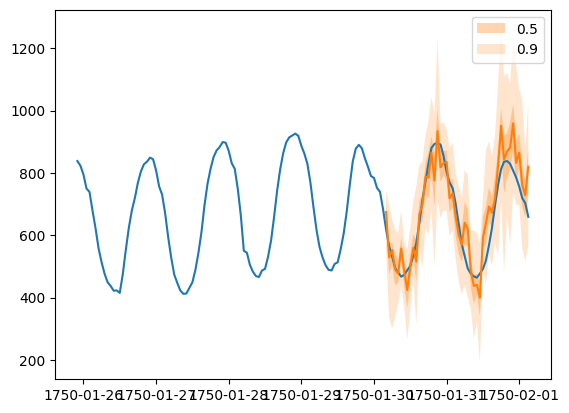

In [24]:
plt.plot(ts_entry[-150:].to_timestamp())
forecast_entry.plot(show_label=True)
plt.legend()

We can also evaluate the quality of our forecasts numerically. In GluonTS, the `Evaluator` class can compute aggregate performance metrics, as well as metrics per time series (which can be useful for analyzing performance across heterogeneous time series).

In [25]:
from gluonts.evaluation import Evaluator

In [26]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(tss, forecasts)

Running evaluation: 0it [00:00, ?it/s]

Running evaluation: 414it [00:00, 10624.40it/s]

The aggregate metrics, `agg_metrics`, aggregate both across time-steps and across time series.

In [27]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 16329573.814964226,
    "abs_error": 11933158.091949463,
    "abs_target_sum": 145558863.59960938,
    "abs_target_mean": 7324.822041043146,
    "seasonal_error": 336.9046924038305,
    "MASE": 5.049386626938582,
    "MAPE": 0.27345559364499683,
    "sMAPE": 0.20512321923713941,
    "MSIS": 61.07157329630384,
    "num_masked_target_values": 0.0,
    "QuantileLoss[0.1]": 5556602.551773643,
    "Coverage[0.1]": 0.11750201288244766,
    "QuantileLoss[0.5]": 11933158.165620327,
    "Coverage[0.5]": 0.4442431561996779,
    "QuantileLoss[0.9]": 6741308.127041149,
    "Coverage[0.9]": 0.8657407407407408,
    "RMSE": 4040.9867377862333,
    "NRMSE": 0.551683947424714,
    "ND": 0.08198166567701541,
    "wQuantileLoss[0.1]": 0.03817426444780622,
    "wQuantileLoss[0.5]": 0.08198166618313961,
    "wQuantileLoss[0.9]": 0.04631327808098689,
    "mean_absolute_QuantileLoss": 8077022.94814504,
    "mean_wQuantileLoss": 0.055489736237310905,
    "MAE_Coverage": 0.38858024691358034,
    "

Individual metrics are aggregated only across time-steps.

In [28]:
item_metrics.head()

,item_id,forecast_start,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,num_masked_target_values,ND,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,0,1750-01-30 04:00,4948.845052,2539.474121,31644.0,659.250000,42.371302,1.248621,0.083592,0.080214,0.0,0.080251,13.080795,1085.253955,0.062500,2539.474213,0.583333,1363.691321,1.000000
1,1,1750-01-30 04:00,191141.708333,17088.382812,124149.0,2586.437500,165.107988,2.156213,0.146044,0.131018,0.0,0.137644,12.828437,5905.098608,0.187500,17088.382202,0.958333,8071.350879,1.000000
2,2,1750-01-30 04:00,42561.049479,7974.733398,65030.0,1354.791667,78.889053,2.105999,0.115280,0.122587,0.0,0.122632,13.139271,3412.972595,0.000000,7974.733582,0.187500,3504.165015,0.708333
3,3,1750-01-30 04:00,287129.520833,22037.535156,235783.0,4912.145833,258.982249,1.772768,0.093774,0.093618,0.0,0.093465,14.182412,10652.139648,0.083333,22037.536377,0.395833,7379.000879,0.937500
4,4,1750-01-30 04:00,134966.885417,13007.091797,131088.0,2731.000000,200.494083,1.351566,0.103309,0.097902,0.0,0.099224,12.848823,4707.671558,0.083333,13007.091919,0.625000,6769.091797,1.000000


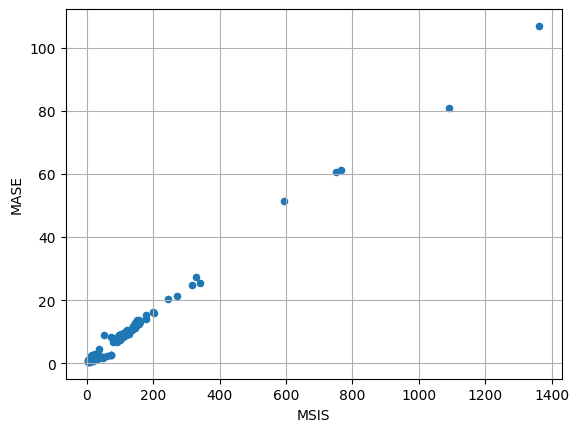

In [29]:
item_metrics.plot(x="MSIS", y="MASE", kind="scatter")
plt.grid(which="both")
plt.show()